# Submission to the ArangoDB Hackathon
## By Patrick Wendo & Sam Chris Kombo

The dataset used in this notebook is available on [Kaggle](https://www.kaggle.com/datasets/andreuvallhernndez/myanimelist)

In [52]:
!pip3 install kagglehub pandas numpy networkx matplotlib nx_arangodb scipy python-dotenv scikit-learn
!pip3 install --upgrade langchain langchain-community langchain-openai langgraph

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
from arango import ArangoClient
from dotenv import load_dotenv

import networkx as nx
import nx_arangodb as nxadb
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import ast
import re
import os
import openai

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

load_dotenv()

sambanova_key = os.getenv("SAMBANOVA_KEY")

db = ArangoClient(hosts="http://localhost:8529").db("hackathon", username="root", password=os.getenv("ARANGO_DB_PASS"), verify=True)

print(db)

anime = pd.read_csv(
    "./datasets/myanimelist/anime.csv"
)

anime.head()


<StandardDatabase hackathon>


,anime_id,title,type,score,scored_by,status,episodes,start_date,end_date,source,...,producers,licensors,synopsis,background,main_picture,url,trailer_url,title_english,title_japanese,title_synonyms
0,5114,Fullmetal Alchemist: Brotherhood,tv,9.10,2037075,finished_airing,64.0,2009-04-05,2010-07-04,manga,...,"['Aniplex', 'Square Enix', 'Mainichi Broadcast...","['Funimation', 'Aniplex of America']",After a horrific alchemy experiment goes wrong...,NaN,https://cdn.myanimelist.net/images/anime/1208/...,https://myanimelist.net/anime/5114/Fullmetal_A...,https://www.youtube.com/watch?v=--IcmZkvL0Q,Fullmetal Alchemist: Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,['Hagane no Renkinjutsushi: Fullmetal Alchemis...
1,11061,Hunter x Hunter (2011),tv,9.04,1671587,finished_airing,148.0,2011-10-02,2014-09-24,manga,...,"['VAP', 'Nippon Television Network', 'Shueisha']",['VIZ Media'],Hunters devote themselves to accomplishing haz...,NaN,https://cdn.myanimelist.net/images/anime/1337/...,https://myanimelist.net/anime/11061/Hunter_x_H...,https://www.youtube.com/watch?v=D9iTQRB4XRk,Hunter x Hunter,HUNTER×HUNTER（ハンター×ハンター）,['HxH (2011)']
2,38524,Shingeki no Kyojin Season 3 Part 2,tv,9.05,1491491,finished_airing,10.0,2019-04-29,2019-07-01,manga,...,"['Production I.G', 'Dentsu', 'Mainichi Broadca...",['Funimation'],Seeking to restore humanity's diminishing hope...,Shingeki no Kyojin adapts content from volumes...,https://cdn.myanimelist.net/images/anime/1517/...,https://myanimelist.net/anime/38524/Shingeki_n...,https://www.youtube.com/watch?v=hKHepjfj5Tw,Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,[]
3,9253,Steins;Gate,tv,9.07,1348232,finished_airing,24.0,2011-04-06,2011-09-14,visual_novel,...,"['Frontier Works', 'Media Factory', 'Kadokawa ...",['Funimation'],Eccentric scientist Rintarou Okabe has a never...,Steins;Gate is based on 5pb. and Nitroplus' vi...,https://cdn.myanimelist.net/images/anime/1935/...,https://myanimelist.net/anime/9253/Steins_Gate,https://www.youtube.com/watch?v=27OZc-ku6is,Steins;Gate,STEINS;GATE,[]
4,28851,Koe no Katachi,movie,8.94,1540277,finished_airing,1.0,2016-09-17,2016-09-17,manga,...,"['Shochiku', 'Pony Canyon', 'Kodansha', 'ABC A...","['Eleven Arts', 'NYAV Post']","As a wild youth, elementary school student Sho...",Koe no Katachi won the following awards: Japan...,https://cdn.myanimelist.net/images/anime/1122/...,https://myanimelist.net/anime/28851/Koe_no_Kat...,https://www.youtube.com/watch?v=XBNWo25izJ8,A Silent Voice,聲の形,['The Shape of Voice']


In [54]:
anime

,anime_id,title,type,score,scored_by,status,episodes,start_date,end_date,source,...,producers,licensors,synopsis,background,main_picture,url,trailer_url,title_english,title_japanese,title_synonyms
0,5114,Fullmetal Alchemist: Brotherhood,tv,9.10,2037075,finished_airing,64.0,2009-04-05,2010-07-04,manga,...,"['Aniplex', 'Square Enix', 'Mainichi Broadcast...","['Funimation', 'Aniplex of America']",After a horrific alchemy experiment goes wrong...,NaN,https://cdn.myanimelist.net/images/anime/1208/...,https://myanimelist.net/anime/5114/Fullmetal_A...,https://www.youtube.com/watch?v=--IcmZkvL0Q,Fullmetal Alchemist: Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,['Hagane no Renkinjutsushi: Fullmetal Alchemis...
1,11061,Hunter x Hunter (2011),tv,9.04,1671587,finished_airing,148.0,2011-10-02,2014-09-24,manga,...,"['VAP', 'Nippon Television Network', 'Shueisha']",['VIZ Media'],Hunters devote themselves to accomplishing haz...,NaN,https://cdn.myanimelist.net/images/anime/1337/...,https://myanimelist.net/anime/11061/Hunter_x_H...,https://www.youtube.com/watch?v=D9iTQRB4XRk,Hunter x Hunter,HUNTER×HUNTER（ハンター×ハンター）,['HxH (2011)']
2,38524,Shingeki no Kyojin Season 3 Part 2,tv,9.05,1491491,finished_airing,10.0,2019-04-29,2019-07-01,manga,...,"['Production I.G', 'Dentsu', 'Mainichi Broadca...",['Funimation'],Seeking to restore humanity's diminishing hope...,Shingeki no Kyojin adapts content from volumes...,https://cdn.myanimelist.net/images/anime/1517/...,https://myanimelist.net/anime/38524/Shingeki_n...,https://www.youtube.com/watch?v=hKHepjfj5Tw,Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,[]
3,9253,Steins;Gate,tv,9.07,1348232,finished_airing,24.0,2011-04-06,2011-09-14,visual_novel,...,"['Frontier Works', 'Media Factory', 'Kadokawa ...",['Funimation'],Eccentric scientist Rintarou Okabe has a never...,Steins;Gate is based on 5pb. and Nitroplus' vi...,https://cdn.myanimelist.net/images/anime/1935/...,https://myanimelist.net/anime/9253/Steins_Gate,https://www.youtube.com/watch?v=27OZc-ku6is,Steins;Gate,STEINS;GATE,[]
4,28851,Koe no Katachi,movie,8.94,1540277,finished_airing,1.0,2016-09-17,2016-09-17,manga,...,"['Shochiku', 'Pony Canyon', 'Kodansha', 'ABC A...","['Eleven Arts', 'NYAV Post']","As a wild youth, elementary school student Sho...",Koe no Katachi won the following awards: Japan...,https://cdn.myanimelist.net/images/anime/1122/...,https://myanimelist.net/anime/28851/Koe_no_Kat...,https://www.youtube.com/watch?v=XBNWo25izJ8,A Silent Voice,聲の形,['The Shape of Voice']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24980,54574,Seizoki,movie,NaN,10,finished_airing,1.0,1964-01-01,1964-01-01,original,...,[],[],"This is an animation using the ""Kaki-mation"" t...",NaN,https://cdn.myanimelist.net/images/anime/1202/...,https://myanimelist.net/anime/54574/Seizoki,NaN,NaN,精造機,[]
24981,56159,Kanshajou,music,NaN,2,finished_airing,1.0,1993-02-02,1993-02-02,original,...,['NHK'],[],Music video for the song Kanshajou by Reiko Sa...,NaN,https://cdn.myanimelist.net/images/anime/1074/...,https://myanimelist.net/anime/56159/Kanshajou,NaN,NaN,感謝状,['Minna no Uta']
24982,56107,Kaijuu Sekai Seifuku,ona,NaN,2,currently_airing,NaN,2020-04-02,NaN,web_manga,...,[],[],Follows four dragon-like monsters who came to ...,NaN,https://cdn.myanimelist.net/images/anime/1859/...,https://myanimelist.net/anime/56107/Kaijuu_Sek...,NaN,NaN,かいじゅうせかいせいふく,[]
24983,56168,Yotsukado no Melody,music,NaN,1,finished_airing,1.0,2014-12-01,2014-12-01,original,...,['NHK'],[],Music video for the song Yotsukado no Melody b...,NaN,https://cdn.myanimelist.net/images/anime/1559/...,https://myanimelist.net/anime/56168/Yotsukado_...,NaN,NaN,四つ角のメロディー,['Minna no Uta']


## DATA EXPLORATION

- We have an anime dataset 
- It is a relational dataset with a single entry having multiple values. We need to figure out how to represent this data as a graph. 

#### Our Strategy.
- We could represent this as an attributed graph with node attributes and edge attributes. An **attributed graph** is one where aside from node labels, or edge labels, a node or an edge will also have additional metadata. For example, in a graph about people, we could have a node with the label "Anna" with attributes `{position: "CEO", start_date: "2019-08-19"}`. 

- The node label would be the name of the anime/manga. We could also have some columns be extracted to nodes of their own. For instance, an anime could fall into multiple genres. We could have each of those as a separate node. Similarly for columns like studios, themes, producers, licensors and demographics.

In [55]:
anime_columns_to_fix = ["genres", "themes", "demographics", "title_synonyms", "studios"]

def rewrite_anime(col):
    anime[col] = anime[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

for col in anime_columns_to_fix:
    rewrite_anime(col)

##### Data Fix #2
- Because the anime, manga, genres, themes, etc etc will use an ID of some kind, we update the anime ID to be prefixed with `a_<id>`
- Further, the ID should not have any disallowed characters, like whitespace, slashes, backslashes, dots at the beginning, colons, asterisks, question marks, exclamation marks, plus signs, percent signs, ampersands or equal signs, so we perform a search and replace for the new fields. 

In [56]:
def sanitize_text(text):
    """Replace spaces with underscores and remove invalid characters."""
    text = re.sub(r'\s+', '_', text)  # Replace spaces with underscores
    text = re.sub(r'[:;]', '', text)  # Remove colons and semicolons
    return text

def update_anime_id(anime_df):
    """Update anime_id by concatenating it with title, then sanitize."""
    anime_df["anime_id"] = anime_df["anime_id"].astype(str) + "_" + anime_df["title"]
    anime_df["anime_id"] = anime_df["anime_id"].apply(sanitize_text)
    
    print(anime_df["anime_id"])  # Debugging output
    return anime_df


anime = update_anime_id(anime)
anime.head(1)


0            5114_Fullmetal_Alchemist_Brotherhood
1                    11061_Hunter_x_Hunter_(2011)
2        38524_Shingeki_no_Kyojin_Season_3_Part_2
3                                 9253_SteinsGate
4                            28851_Koe_no_Katachi
                           ...                   
24980                               54574_Seizoki
24981                             56159_Kanshajou
24982                  56107_Kaijuu_Sekai_Seifuku
24983                   56168_Yotsukado_no_Melody
24984                         56202_Ame_to_Kusari
Name: anime_id, Length: 24985, dtype: object


,anime_id,title,type,score,scored_by,status,episodes,start_date,end_date,source,...,producers,licensors,synopsis,background,main_picture,url,trailer_url,title_english,title_japanese,title_synonyms
0,5114_Fullmetal_Alchemist_Brotherhood,Fullmetal Alchemist: Brotherhood,tv,9.1,2037075,finished_airing,64.0,2009-04-05,2010-07-04,manga,...,"['Aniplex', 'Square Enix', 'Mainichi Broadcast...","['Funimation', 'Aniplex of America']",After a horrific alchemy experiment goes wrong...,NaN,https://cdn.myanimelist.net/images/anime/1208/...,https://myanimelist.net/anime/5114/Fullmetal_A...,https://www.youtube.com/watch?v=--IcmZkvL0Q,Fullmetal Alchemist: Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,[Hagane no Renkinjutsushi: Fullmetal Alchemist...


#### Data fix #3

- Arango DB requires a field with the key `_key` to function as the key for a node. 
- Any value that will become a node should have this key. 


In [57]:
def add_key_column(dataframe, id_column):
    dataframe['_key'] = dataframe[id_column]
    return dataframe

anime = add_key_column(anime, "anime_id")

#### Data Fix #4 
- We want specific columns to become individual dataframes. For instance, `"genres"`, `"title_synonyms"`, `"themes"`, `"demographics"` and `"studios"` should be their own dataframes because each value in those dataframe will be their own nodes.



In [58]:
## Identify Key groups in the following columns: "genres", "themes", "demographics", "studios". These could be shared between anime entries.

def fix_keys(df):
    df["_key"] = df["_key"].astype(str).replace("-", "_", regex=True)
    df["_key"] = df["_key"].astype(str).replace(" ", "_", regex=True)
    return df

def build_new_dataframe(dataframe, column):
    new_explode = anime.explode(column)
    new_dataframe = new_explode.groupby(column)
    new_dataframe = new_dataframe.groups.keys()
    new_dataframe = pd.DataFrame(new_dataframe, columns=[column]).reset_index()
    new_dataframe = add_key_column(new_dataframe, column)
    new_dataframe = fix_keys(new_dataframe)
    new_dataframe = new_dataframe[[column, "_key"]]
    new_dataframe["type"] = column
    return new_dataframe


genre_dataframe = build_new_dataframe(anime, "genres")
demographics_dataframe = build_new_dataframe(anime, "demographics")
studios_dataframe = build_new_dataframe(anime, "studios")
themes_dataframe = build_new_dataframe(anime, "themes")
title_synonyms_dataframe = build_new_dataframe(anime, "title_synonyms")
genre_dataframe
len(anime.columns)

40

#### Data Fix #5
- removing unused attributes from the anime dataset. 
- Some columns in the dataset will not be used in defining the attributes for the anime dataset. We filter these out. 

In [59]:
# anime node attributes
node_label = "anime_id"
node_attributes = {
    "_key": "_key",
    "id": "anime_id",
    "name": "title",
    "type": "type", 
    "score": "score", 
    "status": "status",
    "start_date": "real_start_date", 
    "studios": "studios",
    "themes": "themes",
    "demographics": "demographics",
    "genres": "genres",
    "end_date": "real_end_date", 
    "source": "source", 
    "episode_duration": "episode_duration", 
    "total_duration": "total_duration",
    "sfw": "sfw", 
    "start_year": "start_year", 
    "start_season": "start_season", 
    "broadcast_day": "broadcast_day",
    "main_picture": "main_picture",
    "url": "url",
    "trailer_url": "trailer_url",
    "title_english": "title_english",
    "title_japanese": "title_japanese",
    "title_synonyms": "title_synonyms" 
}

# (node_attributes.values())
anime = anime[anime.columns.intersection(list(node_attributes.values()))]

#### Data Fix 6
- We drop the NaN columns

In [60]:
anime.dropna(inplace=True)
anime

/tmp/ipykernel_34994/1893779218.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime.dropna(inplace=True)


,anime_id,title,type,score,status,source,episode_duration,total_duration,sfw,start_year,...,themes,demographics,studios,main_picture,url,trailer_url,title_english,title_japanese,title_synonyms,_key
0,5114_Fullmetal_Alchemist_Brotherhood,Fullmetal Alchemist: Brotherhood,tv,9.10,finished_airing,manga,0 days 00:24:20,1 days 01:57:20,True,2009.0,...,[Military],[Shounen],[Bones],https://cdn.myanimelist.net/images/anime/1208/...,https://myanimelist.net/anime/5114/Fullmetal_A...,https://www.youtube.com/watch?v=--IcmZkvL0Q,Fullmetal Alchemist: Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,[Hagane no Renkinjutsushi: Fullmetal Alchemist...,5114_Fullmetal_Alchemist_Brotherhood
1,11061_Hunter_x_Hunter_(2011),Hunter x Hunter (2011),tv,9.04,finished_airing,manga,0 days 00:23:37,2 days 10:15:16,True,2011.0,...,[],[Shounen],[Madhouse],https://cdn.myanimelist.net/images/anime/1337/...,https://myanimelist.net/anime/11061/Hunter_x_H...,https://www.youtube.com/watch?v=D9iTQRB4XRk,Hunter x Hunter,HUNTER×HUNTER（ハンター×ハンター）,[HxH (2011)],11061_Hunter_x_Hunter_(2011)
2,38524_Shingeki_no_Kyojin_Season_3_Part_2,Shingeki no Kyojin Season 3 Part 2,tv,9.05,finished_airing,manga,0 days 00:23:55,0 days 03:59:10,True,2019.0,...,"[Gore, Military, Survival]",[Shounen],[Wit Studio],https://cdn.myanimelist.net/images/anime/1517/...,https://myanimelist.net/anime/38524/Shingeki_n...,https://www.youtube.com/watch?v=hKHepjfj5Tw,Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,[],38524_Shingeki_no_Kyojin_Season_3_Part_2
3,9253_SteinsGate,Steins;Gate,tv,9.07,finished_airing,visual_novel,0 days 00:24:20,0 days 09:44:00,True,2011.0,...,"[Psychological, Time Travel]",[],[White Fox],https://cdn.myanimelist.net/images/anime/1935/...,https://myanimelist.net/anime/9253/Steins_Gate,https://www.youtube.com/watch?v=27OZc-ku6is,Steins;Gate,STEINS;GATE,[],9253_SteinsGate
7,40028_Shingeki_no_Kyojin_The_Final_Season,Shingeki no Kyojin: The Final Season,tv,8.80,finished_airing,manga,0 days 00:23:55,0 days 06:22:40,True,2021.0,...,"[Gore, Military, Survival]",[Shounen],[MAPPA],https://cdn.myanimelist.net/images/anime/1000/...,https://myanimelist.net/anime/40028/Shingeki_n...,https://www.youtube.com/watch?v=SlNpRThS9t8,Attack on Titan: Final Season,進撃の巨人 The Final Season,"[Shingeki no Kyojin Season 4, Attack on Titan ...",40028_Shingeki_no_Kyojin_The_Final_Season
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12349,27785_Doamaiger_D,Doamaiger D,tv,5.32,finished_airing,original,0 days 00:02:30,0 days 00:32:30,True,2015.0,...,"[Mecha, Parody]",[],[ILCA],https://cdn.myanimelist.net/images/anime/4/709...,https://myanimelist.net/anime/27785/Doamaiger_D,https://www.youtube.com/watch?v=2An7wL09YiI,Doamayger-D,ドアマイガーD,[],27785_Doamaiger_D
12757,37787_Space_Bug,Space Bug,tv,6.02,finished_airing,original,0 days 00:23:45,0 days 10:17:30,True,2018.0,...,[Space],[],"[Studio W.Baba, P.I.C.S.]",https://cdn.myanimelist.net/images/anime/1063/...,https://myanimelist.net/anime/37787/Space_Bug,https://www.youtube.com/watch?v=ROUtYnPQBDI,The Journey Home,スペースバグ,[],37787_Space_Bug
12827,33975_3-Nen_D-Gumi_Glass_no_Kamen,3-Nen D-Gumi Glass no Kamen,tv,4.65,finished_airing,manga,0 days 00:04:10,0 days 00:54:10,True,2016.0,...,"[Parody, School]",[],[DLE],https://cdn.myanimelist.net/images/anime/7/856...,https://myanimelist.net/anime/33975/3-Nen_D-Gu...,https://www.youtube.com/watch?v=BWNBCb4dzUQ,The Glass Mask Year 3 Class D,３ねんＤぐみガラスの仮面,[],33975_3-Nen_D-Gumi_Glass_no_Kamen
13971,32582_Duel_Masters_VSRF,Duel Masters VSRF,tv,5.47,finished_airing,original,0 days 00:24:00,0 days 20:24:00,True,2016.0,...,[],[Kids],[Ascension],https://cdn.myanimelist.net/images/anime/4/791...,https://myanimelist.net/anime/32582/Duel_Maste...,https://www.youtube.com/watch?v=rIdLEifn894,Duel Masters Versus Revolution Final,デュエル・マスターズVSRF,[],32582_Duel_Masters_VSRF


#### Data fix #7
- Because ArangoDB and NetworkX needs a set of edges, we define an edgelist dataframe that contains only the source key and destination key. 


In [61]:
## Building the edge list. 

def build_edge_list(dataframe1, dataframe2, merge_field_1, merge_field_2):
    exploded_df = dataframe1.explode(merge_field_1)
    edge_list_df = exploded_df.merge(dataframe2, left_on=merge_field_1, right_on=merge_field_2)
    edge_list_df = edge_list_df[["_key_x", "_key_y", "type_y"]]
    print(edge_list_df.columns)
    return edge_list_df

demographics_edge_list = build_edge_list(anime, demographics_dataframe, "demographics", "_key")
genres_edge_list = build_edge_list(anime, genre_dataframe, "genres", "_key")
themes_edge_list = build_edge_list(anime, themes_dataframe, "themes", "_key")
studios_edge_list = build_edge_list(anime, studios_dataframe, "studios", "_key")
# title_synonyms_dataframe = build_edge_list(anime, title_synonyms_dataframe, "title_synonyms", "_key")

Index(['_key_x', '_key_y', 'type_y'], dtype='object')
Index(['_key_x', '_key_y', 'type_y'], dtype='object')
Index(['_key_x', '_key_y', 'type_y'], dtype='object')
Index(['_key_x', '_key_y', 'type_y'], dtype='object')


## Data enriching. 

- For some of the data in the new dataframe, we need to add in descriptions. For instance, for the demographic dataframe, we would need to be able to explain/describe what it is. 

#### Enriching Demographics

In [62]:
# 

demographics_descriptions = {
    'Kodomomuke' : 'This type of anime and manga is deliberately made for children below 12 years of age. They are crafted in a way to teach very young audiences about the values and morals of life to become a good person in life',

    'Kids' : 'This type of anime and manga is deliberately made for children below 12 years of age. They are crafted in a way to teach very young audiences about the values and morals of life to become a good person in life',
    
    'Shonen' : 'This type of anime is generally targeted toward teen boys (12-18 years old) but even teen girls like to watch them. he Shonen anime or manga has a central male protagonist (female in rare cases), and it includes a mix of a wide variety of genres such as adventure, action, drama, sci-fi, and more. It includes an adventurous storyline revolving around the protagonist, who aims to achieve his/ her goals bundled with enthralling battles. Also, they are often seen preaching the value of friendship and family.',
    
    'Shounen': 'This type of anime is generally targeted toward teen boys (12-18 years old) but even teen girls like to watch them. he Shonen anime or manga has a central male protagonist (female in rare cases), and it includes a mix of a wide variety of genres such as adventure, action, drama, sci-fi, and more. It includes an adventurous storyline revolving around the protagonist, who aims to achieve his/ her goals bundled with enthralling battles. Also, they are often seen preaching the value of friendship and family.',
    
    'Shojo': 'Shojo is made for young female audiences. It is crafted for young girls, generally between the ages of 12-18. The Shoujo anime or manga explores the feminine side which basically includes genres such as romance and drama. As opposed to Shonen, Shoujo has a female as the lead and the story revolves around her life. The sub-genres of the Shoujo anime type cover Yaoi and Yuri as well, which we will discuss briefly below. ',
    
    'Shoujo': 'Shojo is made for young female audiences. It is crafted for young girls, generally between the ages of 12-18. The Shoujo anime or manga explores the feminine side which basically includes genres such as romance and drama. As opposed to Shonen, Shoujo has a female as the lead and the story revolves around her life. The sub-genres of the Shoujo anime type cover Yaoi and Yuri as well, which we will discuss briefly below. ',

    'Seinen': 'The literal meaning of Seinen is “youth,” and the anime and manga in this category are targeted toward adult men. So, this anime type covers the audience who are 18 and above in age, predominantly males but is also liked by females. Seinen includes all the elements of a typical Shonen anime but elevates it to the next step by having no theme or story restrictions. As there are no restrictions here, Seinen anime includes mature themes, hence, the 18 years and above age requirement. Seinen also covers a wide variety of mature genres, such as psychological, gore, violence, action, erotic, etc., which suit the adult audience better.',

    'Josei' : 'The term Josei refers to “Woman or Female” and is the equivalent of Seinen for females. Thus, Josei is intended for adult women who are 18 and older. Josei is the improved version of Shoujo and shows the realistic lives of women, including their relationships, challenges, and more. Just like Shoujo, Josei also covers LGBTQ+ storylines such as Yaoi and Yuri sub-genres within them',
}

demographics_dataframe["description"] = ''

for key in demographics_descriptions:
    demographics_dataframe.loc[demographics_dataframe['demographics'] == key, "description"] = demographics_descriptions[key]
demographics_dataframe

,demographics,_key,type,description
0,Josei,Josei,demographics,The term Josei refers to “Woman or Female” and...
1,Kids,Kids,demographics,This type of anime and manga is deliberately m...
2,Seinen,Seinen,demographics,"The literal meaning of Seinen is “youth,” and ..."
3,Shoujo,Shoujo,demographics,Shojo is made for young female audiences. It i...
4,Shounen,Shounen,demographics,This type of anime is generally targeted towar...


In [63]:
genre_dataframe

,genres,_key,type
0,Action,Action,genres
1,Adventure,Adventure,genres
2,Avant Garde,Avant_Garde,genres
3,Award Winning,Award_Winning,genres
4,Boys Love,Boys_Love,genres
5,Comedy,Comedy,genres
6,Drama,Drama,genres
7,Ecchi,Ecchi,genres
8,Erotica,Erotica,genres
9,Fantasy,Fantasy,genres


#### Enriching Genres
- There are about 20 genres, and we want to have a way to update them if new genres come in. As such, we will attempt to fetch genre descriptions from chatGPT.



In [64]:
genre_descriptions = {
    "Action": "The action genre features fast-paced, thrilling, and intense sequences of physical feats, combat, and excitement. The characters of these stories are involved in daring and often dangerous situations, requiring them to rely on their physical prowess, skills, and quick thinking to overcome challenges and adversaries.",

    "Adventure": "The adventure genre features exciting journeys, quests, or expeditions undertaken by characters who often face challenges, obstacles, and risks in pursuit of a goal. Adventures can take place in a wide range of settings, from exotic and fantastical locations to historical or even everyday environments.",

    "Avant Garde": "Experimental fiction which shunned conventional storytelling at the time it was created. These stories often invoke unsettled feelings because they reject traditional ways in which we prefer to view (or escape from) the world. Narrative is avant garde works is often of higher importance than the content. Deconstructions often fall into this genre. Note that simply being darker, edgier, or cynical doesn't mean the work is avant garde",

    "Award Winning" : "Titles which have won prestigious or professional awards in Japan. Examples include the Tokyo Anime Award or Japan Media Arts Festival awards. ",

    "Boys Love": "Depicts homoerotic relationships between male characters. It is typically created by women for a female audience, distinguishing it from the equivalent genre of homoerotic media created by and for gay men, though BL does also attract a male audience and can be produced by male creators.",

    "Comedy": "The comedy genre refers to a category of entertainment that aims to amuse and entertain audiences by using humor, wit, and comedic situations. Comedies are created with the primary intention of eliciting laughter and providing lighthearted enjoyment. They encompass a wide range of styles, tones, and themes, appealing to various tastes and audiences.",

    "Drama": "The drama genre is a broad category that features stories portraying human experiences, emotions, conflicts, and relationships in a realistic and emotionally impactful way. Dramas delve into the complexities of human life, often exploring themes of love, loss, morality, societal issues, personal growth, with the aim to evoke an emotional response from the audience by presenting relatable and thought-provoking stories.",

    "Ecchi": "Ecchi is a slang term in the Japanese language for playfully sexual actions. As an adjective, it is used with the meaning of 'sexy', 'dirty' or 'naughty'; as a verb, ecchi suru means 'to have sex', and as a noun, it is used to describe someone of lascivious behavior. It is softer than the Japanese word ero, and does not imply perversion in the way hentai does. The word ecchi has been adopted by western fans of Japanese media to describe works with sexual overtones. In western culture, it has come to be used to refer to softcore or playful sexuality, as distinct from the word hentai, which connotes perversion or fetishism. ", 

    "Erotica": "Anime hentai refers to a subgenre of Japanese animation that incorporates explicit sexual content. It gained popularity in the late 20th century and continues to be a prominent category within the anime industry.",

    "Fantasy" : "The fantasy genre features imaginative and often magical worlds, characters, and events. It explores realms beyond the boundaries of reality, featuring elements such as magic, mythical creatures, supernatural powers, and fantastical settings. These stories can take place in entirely fictional worlds or blend fantastical elements with real-world settings.",

    "Game": "These anime encompass shows that mainly focus on gaming and playing themes. For instance, anime may include characters playing board games, card games, puzzle games, and virtual online games.",

    "Girls Love": "Same-sex romantic/sexual relationships between women are the focus of these stories. In Japan, the term Yuri is commonly used to refer this media. Girls Love and its abbreviation GL are also used, but to a lesser extent. These stories vary in their explicit content levels, with some focusing mainly on relationship development and others incorporating more sexual content.",

    "Gourmet": "Preparation and consumption of food or drink take focus in gourmet stories and the narrative is designed to feature numerous different dishes or beverages. Characters are often chefs or food connoisseurs, and special attention is given to all steps in the cooking process, ranging from detailed descriptions of recipes to the characters' often over-the-top reactions when tasting the finished product. Gourmet should only be double-tagged with Workplace when the social interactions between multiple employees in the same work environment are equal in focus to the food/drink.",

    "Hentai": "Anime hentai refers to a subgenre of Japanese animation that incorporates explicit sexual content. It gained popularity in the late 20th century and continues to be a prominent category within the anime industry. ",

    "Horror" : "It’s obvious to come across several incidences of bloody violence and heavy gore traits in these animes. The key distinguishing factor in horror animes is the ability to creep and scare you out. If you are watching horror anime types alone, it can be frightening, especially if it’s your first time.",

    "Mystery": "Mystery animes are a psychological-based genre that mainly focuses on mysterious places, items, or events. One common thing about mystery anime stories is the red herrings that keep fans guessing. ",

    "Mecha": "Mecha is a subgenre of Japanese animation that features giant robots or mechs that are controlled by pilots or artificial intelligence",

    "Military": "The military genre mainly features uniformed military as the main characters. One common feature of military anime is that Mecha animes accompany it. In comparison, Mecha anime is characterized primarily by science fiction robots. ",

    "Police": "As the name suggests, these anime emphasize ordinary law enforcers’ challenges and struggles in their work. Police-based characters are featured in various shows, and some emerge as police procedurals. ",

    "Post Apocalyptic": "The post-apocalyptic anime mainly involves typical shows of how the world would look at the end of the world. For instance, how would the world look if it had been destroyed with only a few humans surviving the apocalypse? ",

    "Psychological": "These animes mainly revolve around how the psyche and mind work. This genre mainly covers scenes touching psychological themes and rarely on philosophical levels. Mind games and battles are standard here; the characters have to gauge their wits against the competitor. Psychological animes are designed to involve your mind by sharpening your critical thinking skills.",

    "Romance": "The romance genre features the theme of romantic relationships and emotional connections between characters. These stories focus on the development of love, desire, and intimacy between protagonists, often exploring the challenges, conflicts, and triumphs that arise in their relationships.",

    "Sci-Fi": "The sci-fi genre, short for science fiction, features imaginative and futuristic concepts that are often rooted in scientific principles, technology, and possibilities. These stories delve into 'what if' questions and can serve as a platform to address contemporary social, political, and ethical issues by projecting them onto future or alternate settings.",

    "Slice of Life": "Slice of life is a subgenre of Japanese animation that portrays everyday life, often without a central plot or overarching narrative. Instead, slice of life anime captures the ordinary experiences, interactions, and emotions of its characters, offering a glimpse into their daily routines and struggles.",

    "Sports": "These are shows whose characters mainly participate in athletic competitions. Popular choices of sports anime include tennis, basketball anime, baseball, and soccer.",

    "Supernatural": "Magical-based animes may cover mythical, bizarre, and mystical things or something beyond the accepted reality. There are shadows of myths and mysteries found in this genre.",

    "Suspense": "Instilling a sense of anticipation and excitement takes priority, and is accomplished with a narrative that is rife with twists, turns, and red herrings. Uncertainty is present every step of the way, often drawn out for maximum effect. A variety of tools are used to keep the audience on the edge of their seats, such as withholding important information, intentional misdirection, or even outright subversion of expectations. Suspenseful moments do not mean a work is Suspense; the feeling of anticipation or anxiety must be maintained throughout the story. Contrast with Horror where the audience is in a constant state of apprehension and dreads the next event, rather than craving it. While Mystery also instills anticipation, the tension is focused on discovering the solution to a puzzle, rather than knowing what the characters will do next. Sometimes a story can mix Suspense with Horror or Mystery, but this is rare."
}
    

for key in genre_descriptions:
    genre_dataframe.loc[genre_dataframe['genres'] == key, "description"] = genre_descriptions[key]
genre_dataframe

,genres,_key,type,description
0,Action,Action,genres,"The action genre features fast-paced, thrillin..."
1,Adventure,Adventure,genres,The adventure genre features exciting journeys...
2,Avant Garde,Avant_Garde,genres,Experimental fiction which shunned conventiona...
3,Award Winning,Award_Winning,genres,Titles which have won prestigious or professio...
4,Boys Love,Boys_Love,genres,Depicts homoerotic relationships between male ...
5,Comedy,Comedy,genres,The comedy genre refers to a category of enter...
6,Drama,Drama,genres,The drama genre is a broad category that featu...
7,Ecchi,Ecchi,genres,Ecchi is a slang term in the Japanese language...
8,Erotica,Erotica,genres,Anime hentai refers to a subgenre of Japanese ...
9,Fantasy,Fantasy,genres,The fantasy genre features imaginative and oft...


#### Enriching with similiarity indices

- Here we add similarity indices between anime using genres, and themes. 

- We will use cosine similarity, 

$$
\text{similarity}(A, B) = \frac{\sum_{i=1}^{n} A_i B_i}{\sqrt{\sum_{i=1}^{n} A_i^2} \times \sqrt{\sum_{i=1}^{n} B_i^2}}
$$


In [65]:
anime['genres']

0         [Action, Adventure, Drama, Fantasy]
1                [Action, Adventure, Fantasy]
2                             [Action, Drama]
3                   [Drama, Sci-Fi, Suspense]
7                             [Action, Drama]
                         ...                 
12349               [Action, Comedy, Gourmet]
12757                             [Adventure]
12827                                [Comedy]
13971    [Action, Adventure, Comedy, Fantasy]
14605                                      []
Name: genres, Length: 1732, dtype: object

In [66]:
# vectorizer = TfidfVectorizer()
# # Convert genres into TF-IDF features.
# tfidf_matrix = vectorizer.fit_transform(anime['genres'])

# # # Here we compute the cosine similarity. 
# similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

# # # convert similarity matrix into a dataframe
# # similarity_df = pd.DataFrame(similarity_matrix, index=anime['title'], columns=anime['title'])
# # similarity_df

# print(similarity_matrix.shape)


### NetworkX

- Let's attempt to add the nodes from the dataframes and the edges from the edgelist

In [67]:
genre_dataframe

,genres,_key,type,description
0,Action,Action,genres,"The action genre features fast-paced, thrillin..."
1,Adventure,Adventure,genres,The adventure genre features exciting journeys...
2,Avant Garde,Avant_Garde,genres,Experimental fiction which shunned conventiona...
3,Award Winning,Award_Winning,genres,Titles which have won prestigious or professio...
4,Boys Love,Boys_Love,genres,Depicts homoerotic relationships between male ...
5,Comedy,Comedy,genres,The comedy genre refers to a category of enter...
6,Drama,Drama,genres,The drama genre is a broad category that featu...
7,Ecchi,Ecchi,genres,Ecchi is a slang term in the Japanese language...
8,Erotica,Erotica,genres,Anime hentai refers to a subgenre of Japanese ...
9,Fantasy,Fantasy,genres,The fantasy genre features imaginative and oft...


In [68]:
# Adding nodes for "genres", "themes", "demographics", "studios"
# G = nx.Graph()

# def add_nodes(G, node_df, key):
#     for index, row in node_df.iterrows():
#         node_id = row[key]  # Get node identifier (_key)
#         attributes = row.drop(key).to_dict()  # Convert other columns to a dictionary
#         G.add_node(node_id, **attributes)

# add_nodes(G, anime, "_key")
# add_nodes(G, genre_dataframe, "genres")
# add_nodes(G, themes_dataframe, "themes")
# add_nodes(G, demographics_dataframe, "demographics")
# add_nodes(G, studios_dataframe, "studios")

# # # Add edgelists
# G.add_edges_from(genres_edge_list[["_key_x", "_key_y"]].itertuples(index=False, name=None))
# G.add_edges_from(demographics_edge_list[["_key_x", "_key_y"]].itertuples(index=False, name=None))
# G.add_edges_from(studios_edge_list[["_key_x", "_key_y"]].itertuples(index=False, name=None))
# G.add_edges_from(themes_edge_list[["_key_x", "_key_y"]].itertuples(index=False, name=None))


# G = nx.from_pandas_edgelist(genres_edge_list, "_key_y", "_key_x")
G.nodes(data=True)
genres_edge_list


NameError: name 'G' is not defined

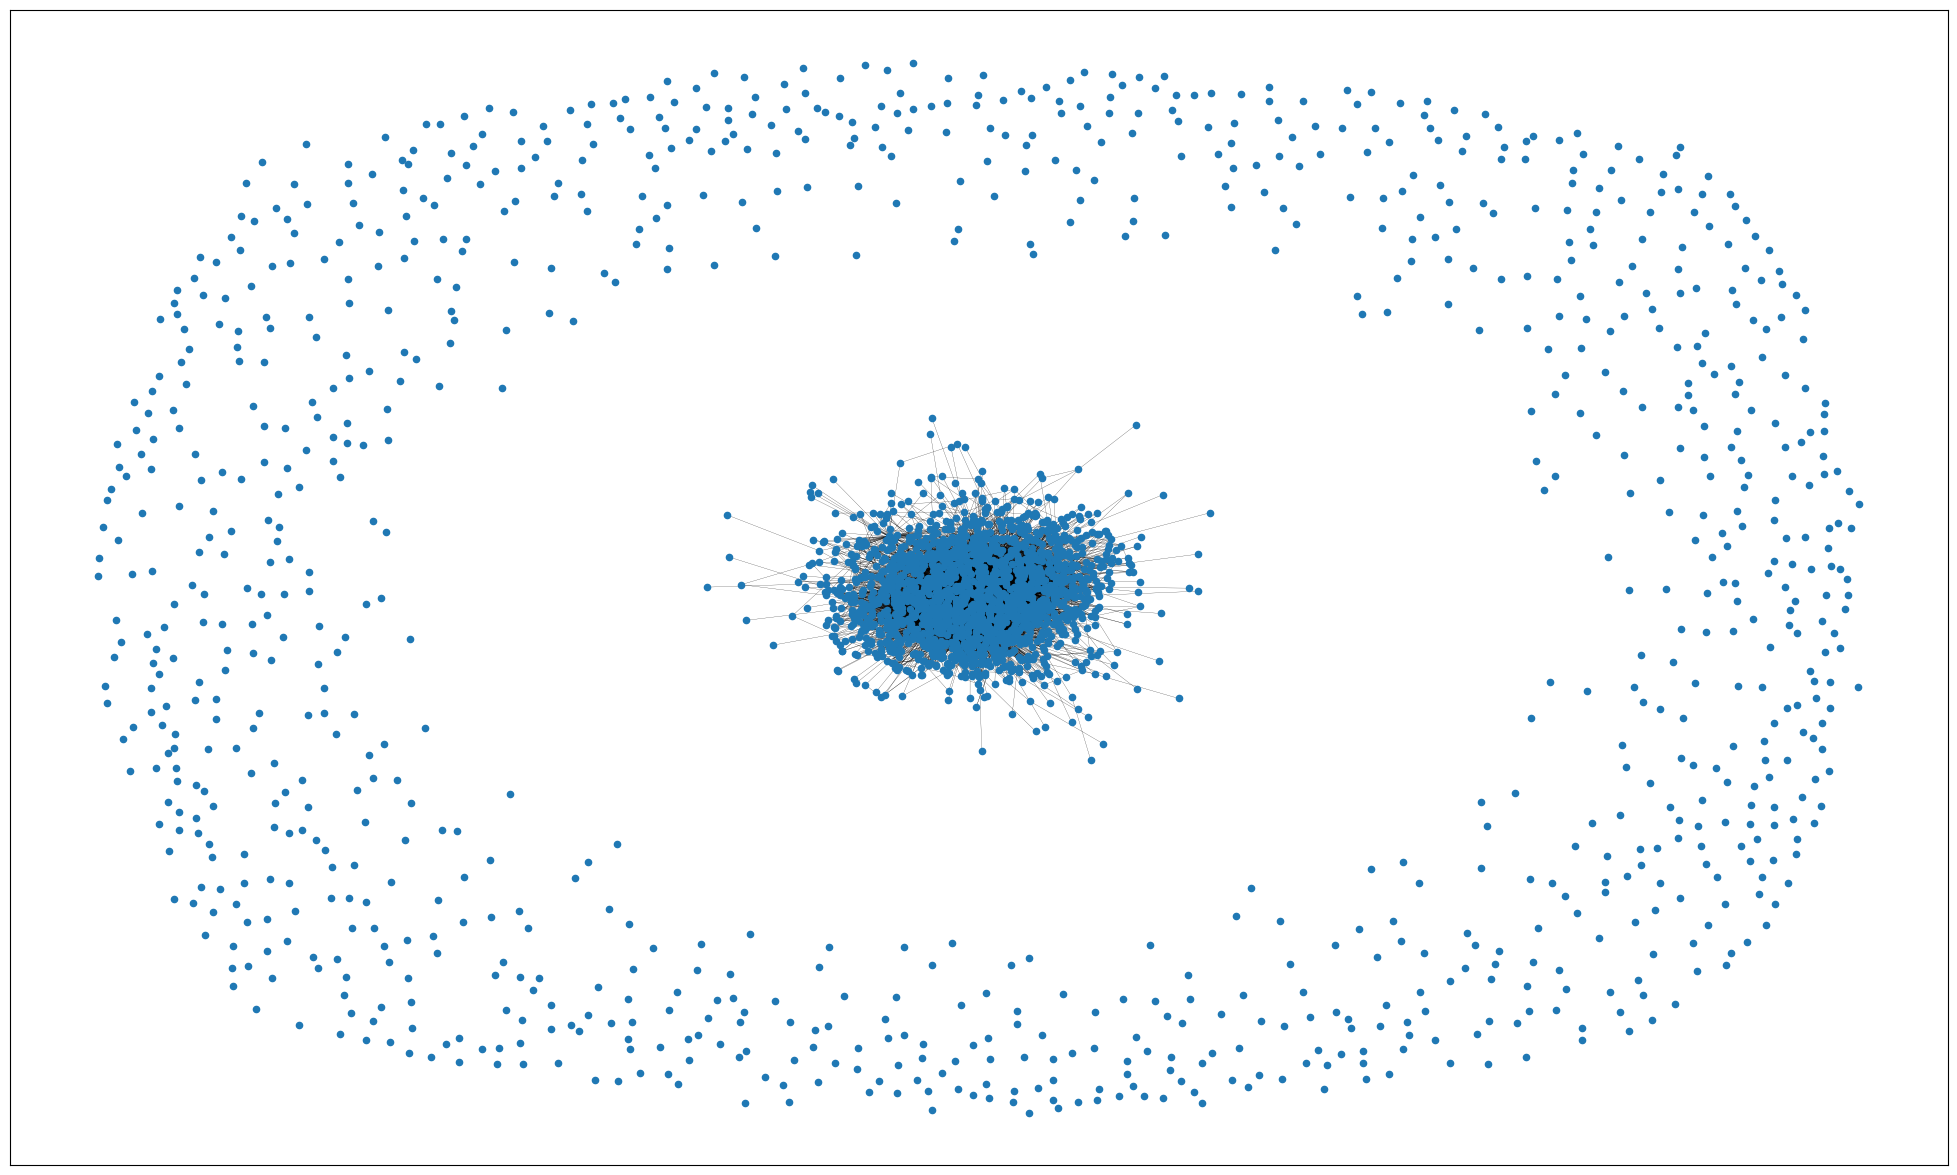

In [ ]:
# plot_options = {"node_size": 20, "with_labels": False, "width": 0.15}
# pos = nx.spring_layout(G, iterations=15, seed=1219)
# fig, ax = plt.subplots(figsize=(25, 15))
# nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

### Load into Arango DB
- Now that we have the graph in networkX, we will load it into ArangoDB

In [ ]:
anime

,anime_id,title,type,score,status,source,episode_duration,total_duration,sfw,start_year,...,themes,demographics,studios,main_picture,url,trailer_url,title_english,title_japanese,title_synonyms,_key
0,5114_Fullmetal_Alchemist_Brotherhood,Fullmetal Alchemist: Brotherhood,tv,9.10,finished_airing,manga,0 days 00:24:20,1 days 01:57:20,True,2009,...,[Military],[Shounen],[Bones],https://cdn.myanimelist.net/images/anime/1208/...,https://myanimelist.net/anime/5114/Fullmetal_A...,https://www.youtube.com/watch?v=--IcmZkvL0Q,Fullmetal Alchemist: Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,[Hagane no Renkinjutsushi: Fullmetal Alchemist...,5114_Fullmetal_Alchemist_Brotherhood
1,11061_Hunter_x_Hunter_(2011),Hunter x Hunter (2011),tv,9.04,finished_airing,manga,0 days 00:23:37,2 days 10:15:16,True,2011,...,[],[Shounen],[Madhouse],https://cdn.myanimelist.net/images/anime/1337/...,https://myanimelist.net/anime/11061/Hunter_x_H...,https://www.youtube.com/watch?v=D9iTQRB4XRk,Hunter x Hunter,HUNTER×HUNTER（ハンター×ハンター）,[HxH (2011)],11061_Hunter_x_Hunter_(2011)
2,38524_Shingeki_no_Kyojin_Season_3_Part_2,Shingeki no Kyojin Season 3 Part 2,tv,9.05,finished_airing,manga,0 days 00:23:55,0 days 03:59:10,True,2019,...,"[Gore, Military, Survival]",[Shounen],[Wit Studio],https://cdn.myanimelist.net/images/anime/1517/...,https://myanimelist.net/anime/38524/Shingeki_n...,https://www.youtube.com/watch?v=hKHepjfj5Tw,Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,[],38524_Shingeki_no_Kyojin_Season_3_Part_2
3,9253_SteinsGate,Steins;Gate,tv,9.07,finished_airing,visual_novel,0 days 00:24:20,0 days 09:44:00,True,2011,...,"[Psychological, Time Travel]",[],[White Fox],https://cdn.myanimelist.net/images/anime/1935/...,https://myanimelist.net/anime/9253/Steins_Gate,https://www.youtube.com/watch?v=27OZc-ku6is,Steins;Gate,STEINS;GATE,[],9253_SteinsGate
7,40028_Shingeki_no_Kyojin_The_Final_Season,Shingeki no Kyojin: The Final Season,tv,8.80,finished_airing,manga,0 days 00:23:55,0 days 06:22:40,True,2021,...,"[Gore, Military, Survival]",[Shounen],[MAPPA],https://cdn.myanimelist.net/images/anime/1000/...,https://myanimelist.net/anime/40028/Shingeki_n...,https://www.youtube.com/watch?v=SlNpRThS9t8,Attack on Titan: Final Season,進撃の巨人 The Final Season,"[Shingeki no Kyojin Season 4, Attack on Titan ...",40028_Shingeki_no_Kyojin_The_Final_Season


#### Dataframes to Collections to load data into ArangoDB Manually
- We will define different node collections for different dataframes. 
- While we can use the networkX arangoDB library to do this, I think it is better if we define our own separate collections and build edges between them manually(for the practice)

In [70]:
def build_collection(collection_name, dataframe, db):
    if not db.has_collection(collection_name):
        db.create_collection(collection_name)
    else:
        db.delete_collection(collection_name)
        db.create_collection(collection_name)

    collection = db.collection(collection_name)

    nodes = dataframe.to_dict(orient='records')
    collection.insert_many(nodes, overwrite=True)

def build_edge_list(edge_list_name, from_type, to_type, edge_df, db):
    edge_df = edge_df.rename(columns={'_key_x': '_from', '_key_y': '_to'})
    # edge_df.iloc(1)
    if not db.has_collection(edge_list_name):
        db.create_collection(edge_list_name, edge=True)
    else:
        db.delete_collection(edge_list_name)
        db.create_collection(edge_list_name, edge=True)

    edge_collection = db.collection(edge_list_name)

    edges = []
    for _, row in edge_df.iterrows():
        edge = {
            '_from': f'{from_type}/{row["_from"]}',
            '_to': f'{to_type}/{row["_to"]}'
        }
        edges.append(edge)
    edge_collection.insert_many(edges, overwrite=True)

graph_name = "anime_graph"
if db.has_graph(graph_name):
    db.delete_graph(graph_name)


build_collection("studios", studios_dataframe, db)
build_collection("themes", themes_dataframe, db)
build_collection("demographics", demographics_dataframe, db)
build_collection("genres", genre_dataframe, db)
build_collection("anime", anime, db)

build_edge_list("genres_edge_list", "anime", "genres", genres_edge_list, db)
build_edge_list("studios_edge_list", "anime", "studios", studios_edge_list, db)
build_edge_list("themes_edge_list", "anime", "themes", themes_edge_list, db)
build_edge_list("demographics_edge_list", "anime", "demographics", demographics_edge_list, db)
genres_edge_list

edge_definitions = [
    {
        "edge_collection": "genres_edge_list",
        "from_vertex_collections": ["anime"],
        "to_vertex_collections": ["genres"]
    },
    {
        "edge_collection": "studios_edge_list",
        "from_vertex_collections": ["anime"],
        "to_vertex_collections": ["studios"]
    },
    {
        "edge_collection": "themes_edge_list",
        "from_vertex_collections": ["anime"],
        "to_vertex_collections": ["themes"]
    },
    {
        "edge_collection": "demographics_edge_list",
        "from_vertex_collections": ["anime"],
        "to_vertex_collections": ["demographics"]
    },
]

vertex_collections = ["anime", "studios", "demographics", "themes", "genres"]

graph = None
if not db.has_graph(graph_name):
    graph = db.create_graph(graph_name, edge_definitions=edge_definitions)
else:
    db.delete_graph(graph_name)
    graph = db.create_graph(graph_name, edge_definitions=edge_definitions)



Having loaded our data into Arango, we can check the schema to see if we got what we wanted.

In [ ]:
# print([len(genre_dataframe), len(anime), len(themes_dataframe), len(demographics_dataframe), len(studios_dataframe)])
import pprint 

anime_graph = ArangoGraph(db)

pprint.pp(anime_graph.schema)

{'Graph Schema': [{'graph_name': 'anime_graph',
                   'edge_definitions': [{'edge_collection': 'demographics_edge_list',
                                         'from_vertex_collections': ['anime'],
                                         'to_vertex_collections': ['demographics']},
                                        {'edge_collection': 'genres_edge_list',
                                         'from_vertex_collections': ['anime'],
                                         'to_vertex_collections': ['genres']},
                                        {'edge_collection': 'studios_edge_list',
                                         'from_vertex_collections': ['anime'],
                                         'to_vertex_collections': ['studios']},
                                        {'edge_collection': 'themes_edge_list',
                                         'from_vertex_collections': ['anime'],
                                         'to_vertex_collections':

In [ ]:
G_adb = nxadb.Graph(
    name=graph_name,
    db=db
)



[20:06:04 +0300] [INFO]: Graph 'anime_graph' exists.
[20:06:04 +0300] [INFO]: Default node type set to 'anime'


In [ ]:
print(G_adb)

Graph named 'anime_graph' with 30 nodes and 28 edges


## Building the Agentic App with LangChain & LangGraph

In [ ]:
anime_graph = ArangoGraph(db)

As a basic test, we use the tool that was in the template document to accept a text string and generate  an aql query, execute it and return a response. 

We ask the agent to **Suggest an anime  with military themes**. In the graph, we have FullMetal Alchemist: Brotherhood and Attack on Titan. 

In [73]:
@tool
def text_to_aql_to_text(query: str):
    """This tool is available to invoke the
    ArangoGraphQAChain object, which enables you to
    translate a Natural Language Query into AQL, execute
    the query, and translate the result back into Natural Language.
    """

    llm = ChatOpenAI(
        temperature=0, 
        model_name="Meta-Llama-3.3-70B-Instruct", 
        openai_api_key=sambanova_key,
        base_url="https://api.sambanova.ai/v1"
    )

    chain = ArangoGraphQAChain.from_llm(
    	llm=llm,
    	graph=anime_graph,
    	verbose=True,
        allow_dangerous_requests=True
    )
    
    result = chain.invoke(query)

    return str(result["result"])

text_to_aql_to_text("Give me an anime that's similar tyo Oshi no ko")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH anime, genres, studios, demographics, themes, genres_edge_list, studios_edge_list, demographics_edge_list, themes_edge_list
LET oshi_no_ko = FIRST(
  FOR doc IN anime
    FILTER doc.title == "Oshi no Ko"
    RETURN doc
)
LET oshi_no_ko_genres = (
  FOR v, e, p IN 1..1 OUTBOUND oshi_no_ko._id genres_edge_list
    RETURN p.vertices[1]
)
LET oshi_no_ko_studios = (
  FOR v, e, p IN 1..1 OUTBOUND oshi_no_ko._id studios_edge_list
    RETURN p.vertices[1]
)
LET oshi_no_ko_demographics = (
  FOR v, e, p IN 1..1 OUTBOUND oshi_no_ko._id demographics_edge_list
    RETURN p.vertices[1]
)
LET oshi_no_ko_themes = (
  FOR v, e, p IN 1..1 OUTBOUND oshi_no_ko._id themes_edge_list
    RETURN p.vertices[1]
)
LET similar_animes = (
  FOR anime IN anime
    FILTER anime._id != oshi_no_ko._id
    LET genres_match = LENGTH(
      INTERSECTION(
        (FOR v, e, p IN 1..1 OUTBOUND anime._id genres_edge_list
          RETURN p.vertices[1]),
    

'Based on the provided information, I will generate a natural language summary.\n\n**Summary:** \nUnfortunately, I couldn\'t find any anime that matches the genres, studios, demographics, or themes of "Oshi no Ko". It\'s possible that "Oshi no Ko" has a unique combination of attributes that don\'t overlap with other anime in the database. If you\'d like to explore more, I can try to suggest anime based on other criteria or provide more information about "Oshi no Ko" itself.'

We see that it does in fact return these 2 anime. But it is a simple query. We go further to build a smarter app than this. 

In [ ]:
@tool
def text_to_nx_algorithm_to_text(query):
    """This tool is available to invoke a NetworkX Algorithm on
    the ArangoDB Graph. You are responsible for accepting the
    Natural Language Query, establishing which algorithm needs to
    be executed, executing the algorithm, and translating the results back
    to Natural Language, with respect to the original query.

    If the query (e.g traversals, shortest path, etc.) can be solved using the Arango Query Language, then do not use
    this tool.
    """

    llm = ChatOpenAI(
        temperature=0, 
        model_name="Meta-Llama-3.3-70B-Instruct", 
        openai_api_key=sambanova_key,
        base_url="https://api.sambanova.ai/v1"
    )

    ######################
    print("1) Generating NetworkX code")

    text_to_nx = llm.invoke(f"""
    I have a NetworkX Graph called `G_adb`. It has the following schema: {anime_graph.schema}

    I have the following graph analysis query: {query}.

    Generate the Python Code required to answer the query using the `G_adb` object.

    Be very precise on the NetworkX algorithm you select to answer this query. Think step by step.

    Only assume that networkx is installed, and other base python dependencies.

    Always set the last variable as `FINAL_RESULT`, which represents the answer to the original query.

    Only provide python code that I can directly execute via `exec()`. Do not provide any instructions.

    Make sure that `FINAL_RESULT` stores a short & consice answer. Avoid setting this variable to a long sequence.

    Your code:
    """).content

    text_to_nx_cleaned = re.sub(r"^```python\n|```$", "", text_to_nx, flags=re.MULTILINE).strip()
    
    print('-'*10)
    print(text_to_nx_cleaned)
    print('-'*10)

    ######################

    print("\n2) Executing NetworkX code")
    global_vars = {"G_adb": G_adb, "nx": nx}
    local_vars = {}
    print(f":: NX CODE :: {[text_to_nx_cleaned, global_vars, local_vars]}")

    try:
        exec(text_to_nx_cleaned, global_vars, local_vars)
        text_to_nx_final = text_to_nx
    except Exception as e:
        print(f"EXEC ERROR: {e}")
        return f"EXEC ERROR: {e}"

        # TODO: Consider experimenting with a code corrector!
        attempt = 1
        MAX_ATTEMPTS = 3

        # while attempt <= MAX_ATTEMPTS
            # ...

    print('-'*10)
    FINAL_RESULT = local_vars["FINAL_RESULT"]
    print(f"FINAL_RESULT: {FINAL_RESULT}")
    print('-'*10)

    ######################

    print("3) Formulating final answer")

    nx_to_text = llm.invoke(f"""
        I have a NetworkX Graph called `G_adb`. It has the following schema: {anime_graph.schema}

        I have the following graph analysis query: {query}.

        I have executed the following python code to help me answer my query:

        ---
        {text_to_nx_final}
        ---

        The `FINAL_RESULT` variable is set to the following: {FINAL_RESULT}.

        Based on my original Query and FINAL_RESULT, generate a short and concise response to
        answer my query.
        
        Your response:
    """).content

    return nx_to_text

# text_to_nx_algorithm_to_text("Give me an anime that started before 2012 ")

In [ ]:
print(anime_graph.schema)

{'Graph Schema': [{'graph_name': 'anime_graph', 'edge_definitions': [{'edge_collection': 'demographics_edge_list', 'from_vertex_collections': ['anime'], 'to_vertex_collections': ['demographics']}, {'edge_collection': 'genres_edge_list', 'from_vertex_collections': ['anime'], 'to_vertex_collections': ['genres']}, {'edge_collection': 'studios_edge_list', 'from_vertex_collections': ['anime'], 'to_vertex_collections': ['studios']}, {'edge_collection': 'themes_edge_list', 'from_vertex_collections': ['anime'], 'to_vertex_collections': ['themes']}]}], 'Collection Schema': [{'collection_name': 'genres', 'collection_type': 'document', 'document_properties': [{'name': '_key', 'type': 'str'}, {'name': '_id', 'type': 'str'}, {'name': '_rev', 'type': 'str'}, {'name': 'genres', 'type': 'str'}, {'name': 'type', 'type': 'str'}], 'example_document': {'_key': 'Action', '_id': 'genres/Action', '_rev': '_jPgSXfS---', 'genres': 'Action', 'type': 'genres'}}, {'collection_name': 'anime', 'collection_type': 'd